In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import nltk
nltk.download('stopwords')

# For better visualization
plt.style.use('ggplot')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [18]:
import pandas as pd

# Use raw string (r"") to avoid issues with backslashes in the file path
df = pd.read_csv(r'C:\Users\Administrator\Downloads\archive (3)\spam.csv', encoding='latin-1')

# Display the first few rows
print(df.head())


  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


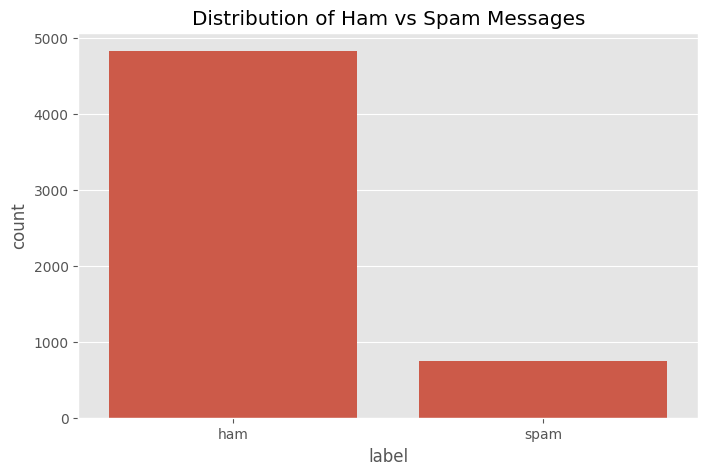

In [19]:
# Drop any extra columns that might have been created during import
df = df[['Category', 'Message']]

# Rename columns for convenience
df.columns = ['label', 'message']

# Check basic info
print(df.info())
print("\nLabel distribution:")
print(df['label'].value_counts())

# Visualize the label distribution
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Ham vs Spam Messages')
plt.show()

In [20]:
# Convert labels to binary (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Text preprocessing function
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Apply stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

# Apply preprocessing
df['processed_message'] = df['message'].apply(preprocess_text)

# Show some examples
print("\nOriginal vs Processed Messages:")
print("Original:", df['message'][0])
print("Processed:", df['processed_message'][0])
print("\nOriginal:", df['message'][2])
print("Processed:", df['processed_message'][2])


Original vs Processed Messages:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: go jurong point crazi avail bugi n great world la e buffet cine got amor wat

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri questionstd txt ratetc appli 08452810075over18


In [21]:
# Using TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_message']).toarray()
y = df['label'].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (4457, 5000)
Test set shape: (1115, 5000)



Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[966   0]
 [ 26 123]]

Accuracy: 0.98


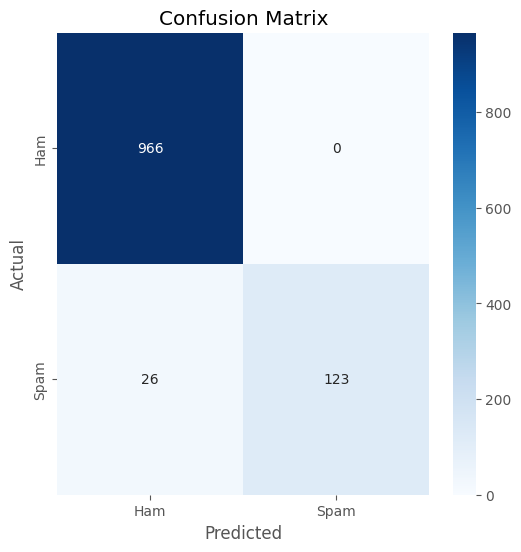

In [22]:
# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
def classify_message(model, tfidf, message):
    # Preprocess
    processed_msg = preprocess_text(message)
    
    # Vectorize
    msg_vector = tfidf.transform([processed_msg]).toarray()
    
    # Predict
    prediction = model.predict(msg_vector)
    
    return "spam" if prediction[0] == 1 else "ham"

# Test with some examples
test_messages = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts",
    "Hey, how are you doing today?",
    "Congratulations! You've won a $1000 Walmart gift card! Click here to claim.",
    "Can we meet tomorrow for lunch?",
    "URGENT! Your bank account has been compromised. Call now to secure your funds."
]

for msg in test_messages:
    print(f"\nMessage: {msg}")
    print(f"Classification: {classify_message(model, tfidf, msg)}")


Message: Free entry in 2 a wkly comp to win FA Cup final tkts
Classification: spam

Message: Hey, how are you doing today?
Classification: ham

Message: Congratulations! You've won a $1000 Walmart gift card! Click here to claim.
Classification: spam

Message: Can we meet tomorrow for lunch?
Classification: ham

Message: URGENT! Your bank account has been compromised. Call now to secure your funds.
Classification: ham


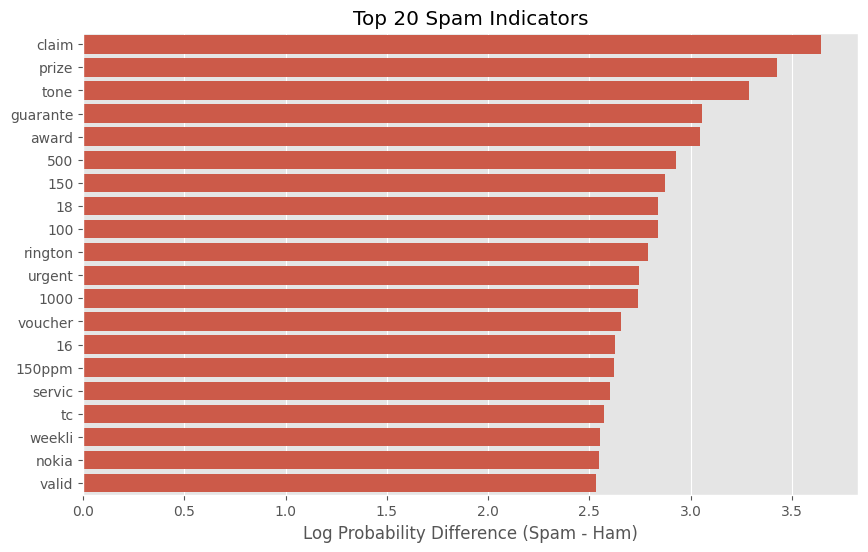

In [24]:
# Get feature names
feature_names = tfidf.get_feature_names_out()

# Get log probabilities for each class
log_prob = model.feature_log_prob_

# Calculate the difference between spam and ham log probabilities
spam_ham_diff = log_prob[1] - log_prob[0]

# Get indices of top 20 spam indicators
top_spam_indices = spam_ham_diff.argsort()[-20:][::-1]

# Get top spam words
top_spam_words = [feature_names[i] for i in top_spam_indices]
top_spam_scores = [spam_ham_diff[i] for i in top_spam_indices]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_spam_scores, y=top_spam_words)
plt.title('Top 20 Spam Indicators')
plt.xlabel('Log Probability Difference (Spam - Ham)')
plt.show()